# FIN 514 - PS4 Q2 LR
**Spring 2022**



In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# input parameters

start_step = 50
N = 1000
S0 = 100.0
K = 100.0
B = 95
r = 0.01
q = 0
sigma = 0.3
T = 0.2 

## Black-Sholes Model 

In [4]:
def bsm(S0, K, B, T, r, q, sigma):

    cdf_mean = 0.0
    cdf_sd = 1.0
    
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    h1 = (np.log(B**2 / (K*S0)) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    h2 = (np.log(B**2 / (K*S0)) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    value = S0 * np.exp(-q * T) * st.norm.cdf(d1, cdf_mean, cdf_sd) 
    value = value - K * np.exp(-r * T) * st.norm.cdf(d2, cdf_mean, cdf_sd) 
    value = value - (B/S0)**(1+2*r/sigma**2)*S0*st.norm.cdf(h1,cdf_mean,cdf_sd)
    value = value + (B/S0)**(-1+2*r/sigma**2)*K*np.exp(-r * T)*st.norm.cdf(h2,cdf_mean,cdf_sd)     
 
    return value

## Binomial Model Function

In [5]:
def LR_CB_fun(S0, K, B, T, r, sigma, start_step, N):
    
    
    # LIST TO SAVE RESULTS
    lr_result = []
        
    # CREATE ARRAY OF SIZE [N+1] TO STORE ALL STEPS
    option_value = np.zeros([N+1])
    stock_value = np.zeros([N+1])    
    
    # FOR LOOP STATEMENT: For a Binomial Tree from start_step to N
    for n in range(start_step, N+1,1):
        delta = T / n
        d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S0 / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        qu = 0.5 + np.sqrt(0.25-0.25*np.exp(-(d2/(n+1/3))**2*(n+1/6)))
        if d2 < 0: 
            qu = 0.5 - np.sqrt(0.25-0.25*np.exp(-(d2/(n+1/3))**2*(n+1/6)))
        qd = 1 - qu    
        qstar = 0.5 + np.sqrt(0.25-0.25*np.exp(-(d1/(n+1/3))**2*(n+1/6)))
        if d1 < 0: 
            qstar = 0.5 - np.sqrt(0.25-0.25*np.exp(-(d1/(n+1/3))**2*(n+1/6)))
        u = np.exp((r-q)*delta)*qstar/qu
        d = (np.exp((r-q)*delta)-qu*u)/(1-qu)
        
    # CALCULATE OPTION VALUES AT CERTAIN STEPS AND POSITIONS WITHIN THE BINOMIAL TREE:

        j = n 
        
        for i in range(0, j):    
            stock_value[i] = S0 * (u**i) * (d**(j - i))
            option_value[i] = np.maximum(stock_value[i]-K, 0)
            
            if stock_value[i] < B:
                sd = stock_value[i]
        
        lamda = (sd*u*u - B)/(sd*u*u - sd)

        for j in range(n-1, -1, -1):
            for i in range(0, j+1):
                stock_value[i] = S0 * (u**i) * (d**(j - i))
                pv = np.exp(-r * delta) * (qu * option_value[i + 1] + qd * option_value[i])
                option_value[i] = pv

                if stock_value[i] < B:
                        option_value[i] = 0
                        
    # RELAY OUTPUTS TO DICTIONARY
        output = {'num_steps': n, 'LR': option_value[0], 'lambda': lamda, 'sd': sd, 'su': sd*u*u}
        lr_result.append(output)

    return lr_result

In [7]:
lr = LR_CB_fun(S0, K, B, T, r, sigma, start_step, N)

In [8]:
bsm_value = bsm(S0, K, B, T, r, q, sigma)
bsm_value

3.706847906251113

In [9]:
df = pd.DataFrame.from_dict(lr)
df['error_LR'] = df["LR"] - bsm_value 
df.to_csv("PS4_Q2", index=False)
df

,num_steps,LR,lambda,sd,su,error_LR
0,50,3.924110,0.363325,92.728120,96.296472,0.217262
1,51,3.917400,0.874413,94.547611,98.149813,0.210552
2,52,3.880372,0.389993,92.862826,96.366349,0.173524
3,53,3.873355,0.900375,94.647656,98.184367,0.166507
4,54,3.838086,0.416131,92.990228,96.432392,0.131238
...,...,...,...,...,...,...
946,996,3.877909,0.034642,94.223534,95.027864,0.171061
947,997,3.877525,0.538583,94.627465,95.434837,0.170677
948,998,3.875605,0.040718,94.229151,95.032720,0.168758
949,999,3.875221,0.544629,94.632696,95.439301,0.168373


### Binomial Model Error Rate

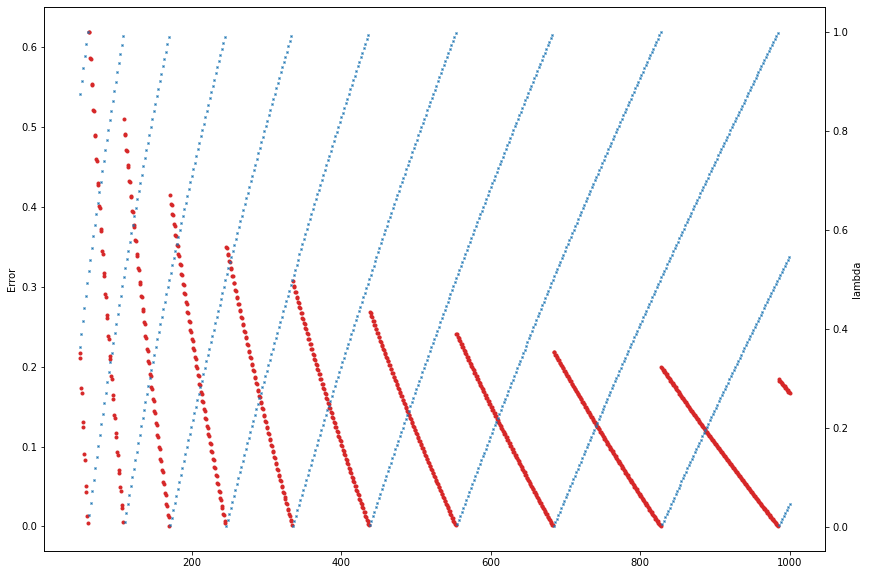

In [10]:
fig, ax1 = plt.subplots(figsize=(14,10))
ax1.set_ylabel('Error')
ax1.plot(df['num_steps'], df['error_LR'], 'o', markersize=3, color = 'tab:red')
ax2 = ax1.twinx()
ax2.set_ylabel('lambda')
ax2.plot(df['num_steps'], df['lambda'], 'x', markersize=2, color = 'tab:blue')
plt.savefig('PS4_Q2_lr.png')
plt.show()

### We can observe from the above figure error rates are minimum at labda = 0

Improving the convergence to the correct value:<br>
-by increasing the number of steps we can acheive convergence or 
<br>
-by selecting steps which shall give a constant lambda convergence can be further improved